In [1]:
import torch
import matplotlib.pyplot as plt
import glob
import math

IndexError: list index out of range

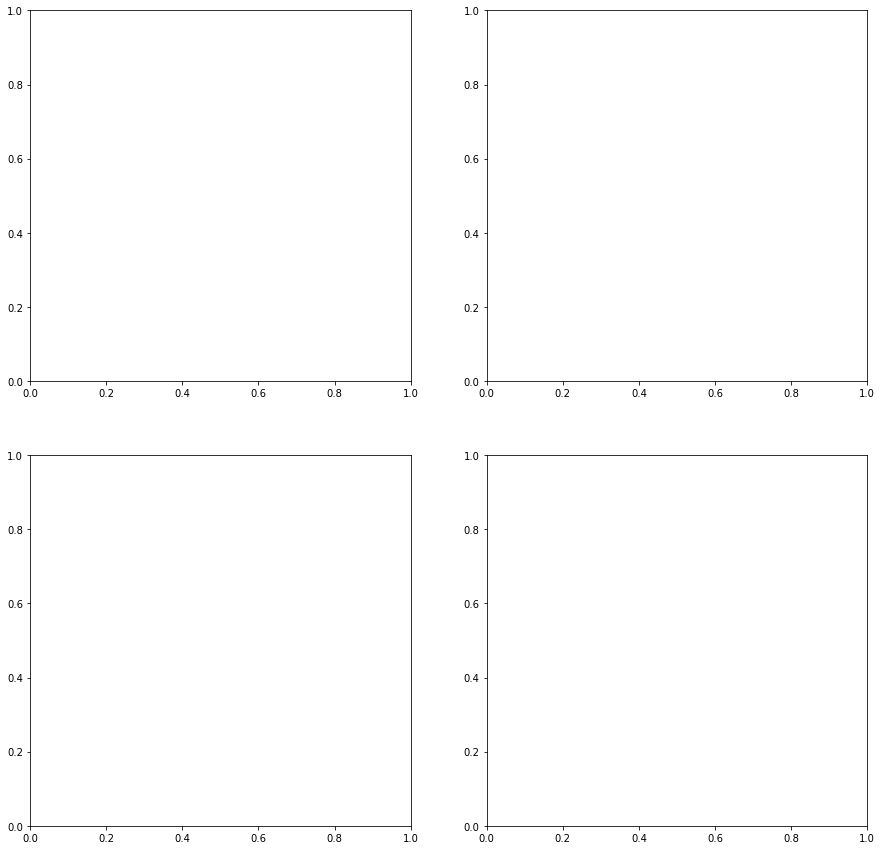

In [33]:
scaling_factors = [1, 2, 4, 8, 16]
fig, axes = plt.subplots(2,2)
fig.set_figwidth(15)
fig.set_figheight(15)
for scaling_factor in scaling_factors:
    file_paths = glob.glob(f'data/gpu_data/*_{scaling_factor}_*.pt')
    file_paths.sort()
    test_accuracy = torch.load(file_paths[0], map_location=torch.device('cpu'))
    test_index = torch.load(file_paths[1],
                            map_location=torch.device('cpu'))
    test_loss = torch.load(file_paths[2], map_location=torch.device('cpu'))
    train_accuracy = torch.load(file_paths[3], map_location=torch.device('cpu'))
    train_index = torch.load(file_paths[4],
                            map_location=torch.device('cpu'))
    train_loss = torch.load(file_paths[5], map_location=torch.device('cpu'))

    axes[0, 0].plot(torch.tensor(test_index)/scaling_factor, test_accuracy, label=f'l={scaling_factor}')
    axes[0, 1].plot(torch.tensor(test_index)/scaling_factor, test_loss, label=f'l={scaling_factor}')
    axes[1, 0].plot(torch.tensor(train_index)/scaling_factor, train_accuracy, label=f'l={scaling_factor}')
    axes[1, 1].plot(torch.tensor(train_index)/scaling_factor, train_loss, label=f'l={scaling_factor}')
for i in range(2):
    for j in range(2):
        axes[i,j].legend()


In [23]:
def average_smoothing(input, n_buckets):
    return torch.tensor([torch.mean(chunk) for chunk in torch.split(input, n_buckets)])


def load_data(base_directory, scaling_factor):
    base = f'{base_directory}/*_{scaling_factor}.pt'
    file_paths = glob.glob(base)
    file_paths.sort()
    test_accuracy = torch.load(
        file_paths[0], map_location=torch.device('cpu'))
    test_loss = torch.load(file_paths[1], map_location=torch.device('cpu'))
    train_accuracy = torch.load(
        file_paths[2], map_location=torch.device('cpu'))
    train_loss = torch.load(
        file_paths[3], map_location=torch.device('cpu'))
    return torch.tensor(test_accuracy), torch.tensor(test_loss), torch.tensor(train_accuracy), torch.tensor(train_loss)


def generate_plot(base_directory, output_name, title, smoothing_factor, loss_lim, val_acc_lim, train_acc_lim):
    scaling_factors = [1, 2, 4, 8, 16]
    fig, axes = plt.subplots(2, 2)
    fig.set_figwidth(9)
    fig.set_figheight(9)
    fig.suptitle(title, fontsize=14)
    for scaling_factor in reversed(scaling_factors):
        test_accuracy, test_loss, train_accuracy, train_loss = load_data(
            base_directory, scaling_factor)
        smoothning_chunks = math.ceil(len(train_loss) * smoothing_factor)
        if smoothing_factor > 0.0:
            train_loss = average_smoothing(train_loss, smoothning_chunks)
            train_accuracy = average_smoothing(
                train_accuracy, smoothning_chunks)
        test_index = torch.linspace(0, 80, len(test_accuracy))
        train_index = torch.linspace(0, 80, len(train_accuracy))
        if scaling_factor == 1:
            axes[0, 0].plot(test_index,
                            test_accuracy, '-.', label=f'SGD l={scaling_factor}')
            axes[0, 1].plot(train_index,
                            train_accuracy, '-.', label=f'SGD l={scaling_factor}')
            axes[1, 0].plot(test_index,
                            test_loss, '-.', label=f'SGD l={scaling_factor}')
            axes[1, 1].plot(train_index,
                            train_loss, '-.', label=f'SGD l={scaling_factor}')
        else:
            axes[0, 0].plot(test_index,
                            test_accuracy, label=f'l={scaling_factor}')
            axes[0, 1].plot(train_index,
                            train_accuracy, label=f'l={scaling_factor}')
            axes[1, 0].plot(test_index,
                            test_loss, label=f'l={scaling_factor}')
            axes[1, 1].plot(train_index,
                            train_loss, label=f'l={scaling_factor}')
    axes[0, 0].set_xlabel('Effective epochs')
    axes[0, 0].set_ylabel('Test accuracy')
    axes[0, 0].set_ylim(val_acc_lim)
    axes[0, 1].set_xlabel('Effective epochs')
    axes[1, 0].set_ylabel('Test loss')
    axes[1, 0].set_ylim(loss_lim)
    axes[1, 0].set_xlabel('Effective epochs')
    axes[0, 1].set_ylabel('Training accuracy')
    axes[0, 1].set_ylim(train_acc_lim)
    axes[1, 1].set_xlabel('Effective epochs')
    axes[1, 1].set_ylabel('Training loss')
    axes[1, 1].set_ylim(loss_lim)
    for i in range(2):
        for j in range(2):
            axes[i, j].legend()
    fig.tight_layout()
    plt.savefig(f'plots/{output_name}.pdf', bbox_inches='tight')
    # plt.show()


In [46]:
x = torch.tensor([1,2,3,4,5,6,7], dtype=torch.float32)
average_smoothing(x, 2)

tensor([1.5000, 3.5000, 5.5000, 7.0000])

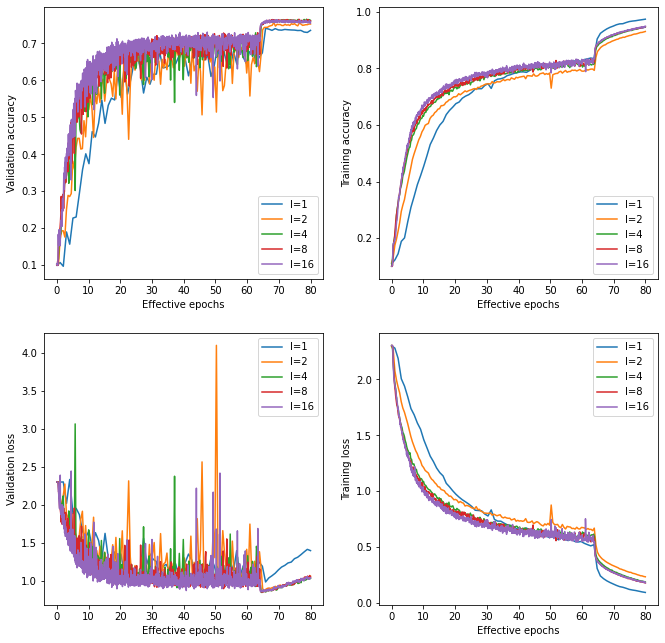

In [21]:
generate_plot('data/alexnet/','alexnet')

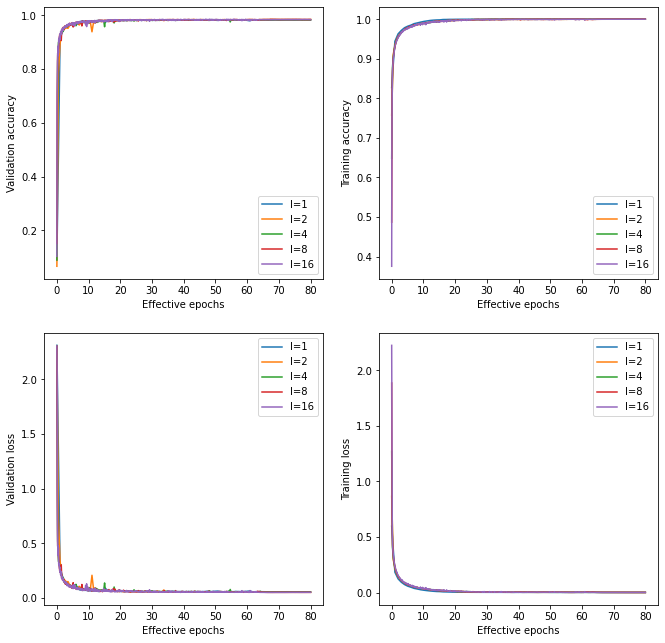

In [24]:
generate_plot('runs/MNIST_2022-12-23_18-45-17/','fc')

ValueError: x and y must have same first dimension, but have shapes torch.Size([640]) and (1280,)

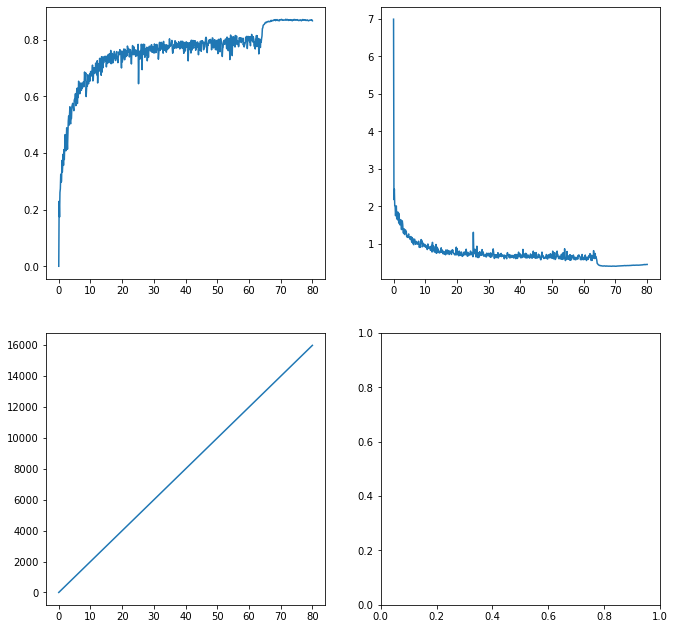

In [35]:
generate_plot('data/gpu_data_1024/','preresnet1024')

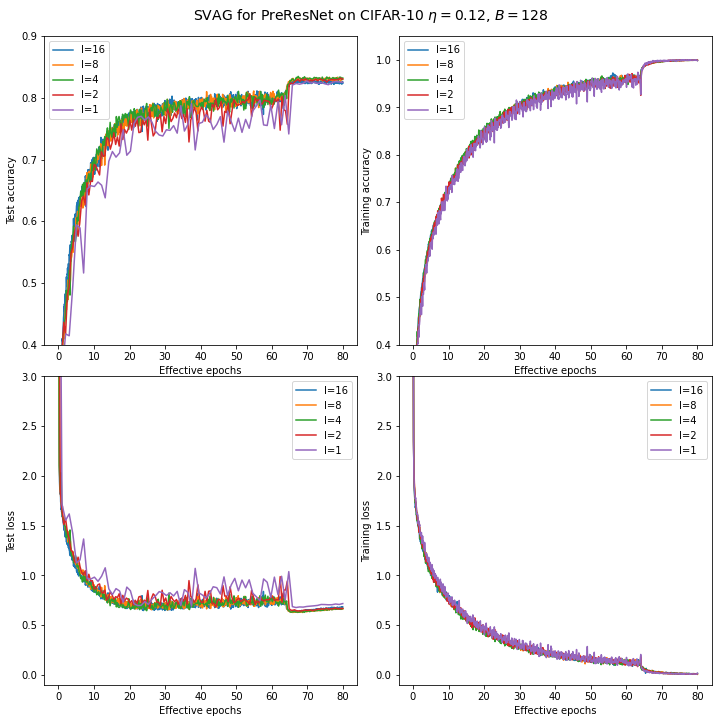

In [131]:
smoothing_factor = 0.001
generate_plot('data/resnet/128/', 'preresnet128_lr012', 'SVAG for PreResNet on CIFAR-10 $\eta=0.12$, $B=128$',
              smoothing_factor, [-0.1, 3], [0.4, 0.9], [0.4, 1.05])


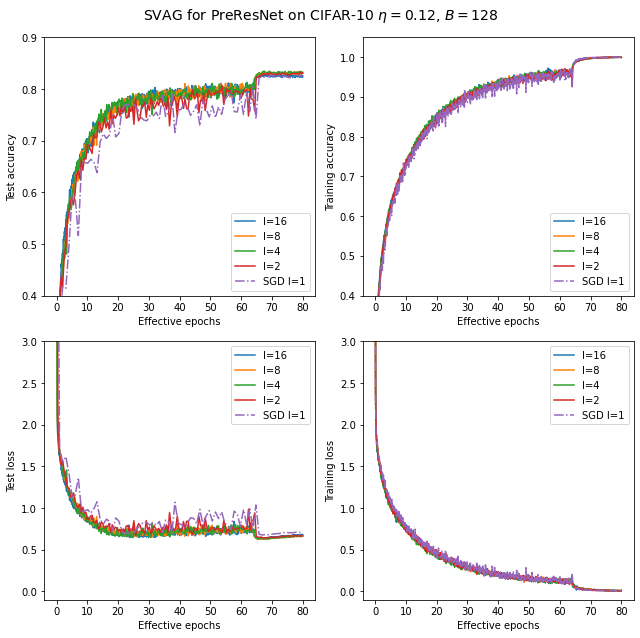

In [28]:
# Presentation
smoothing_factor = 0.001
generate_plot('data/resnet/128/', 'preresnet128_lr012_presentation', 'SVAG for PreResNet on CIFAR-10 $\eta=0.12$, $B=128$',
              smoothing_factor, [-0.1, 3], [0.4, 0.9], [0.4, 1.05])


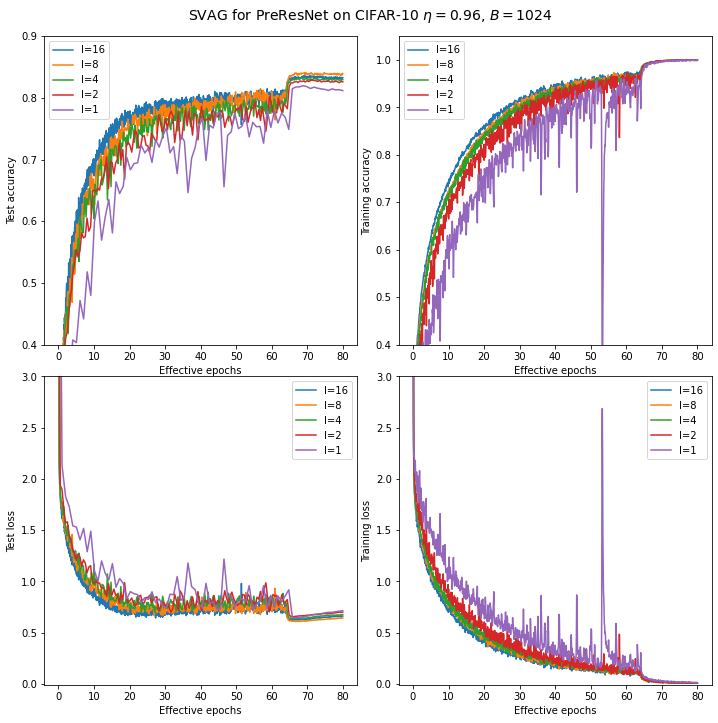

In [132]:
smoothing_factor = 0.001
generate_plot('data/resnet/1024/', 'preresnet1024_lr096', 'SVAG for PreResNet on CIFAR-10 $\eta=0.96$, $B=1024$', smoothing_factor, [-0.01, 3], [0.4, 0.9], [0.4, 1.05])


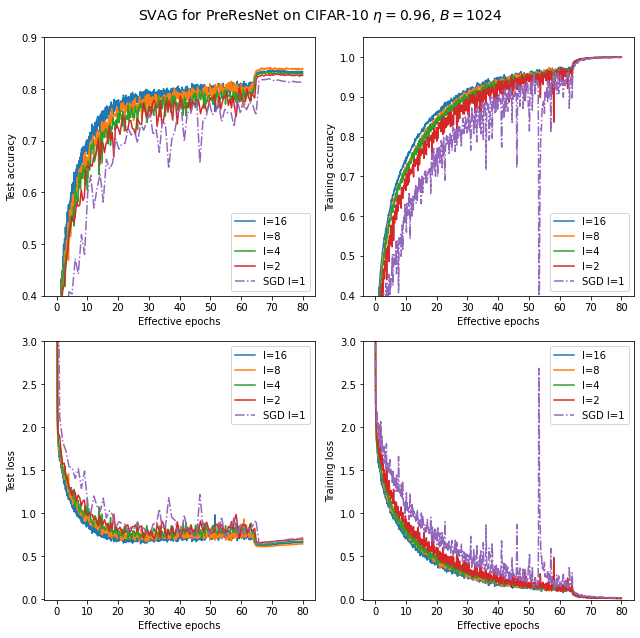

In [27]:
# Presentation
smoothing_factor = 0.001
generate_plot('data/resnet/1024/', 'preresnet1024_lr096_presentation', 'SVAG for PreResNet on CIFAR-10 $\eta=0.96$, $B=1024$',
              smoothing_factor, [-0.01, 3], [0.4, 0.9], [0.4, 1.05])


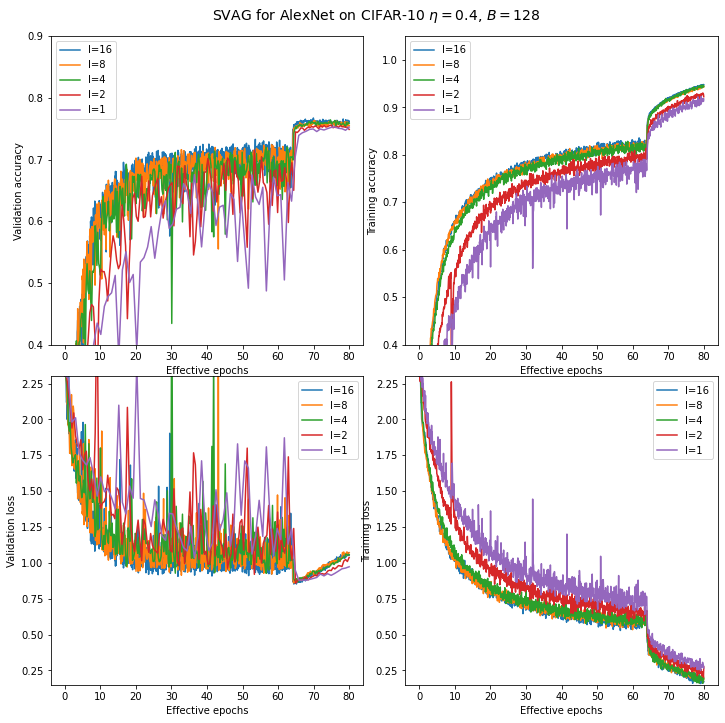

In [129]:
smoothing_factor = 0.001
generate_plot('data/alexnet/128/', 'alexnet128_lr04', 'SVAG for AlexNet on CIFAR-10 $\eta=0.4$, $B=128$',
              smoothing_factor, [0.15, 2.3], [0.4, 0.9], [0.4, 1.05])


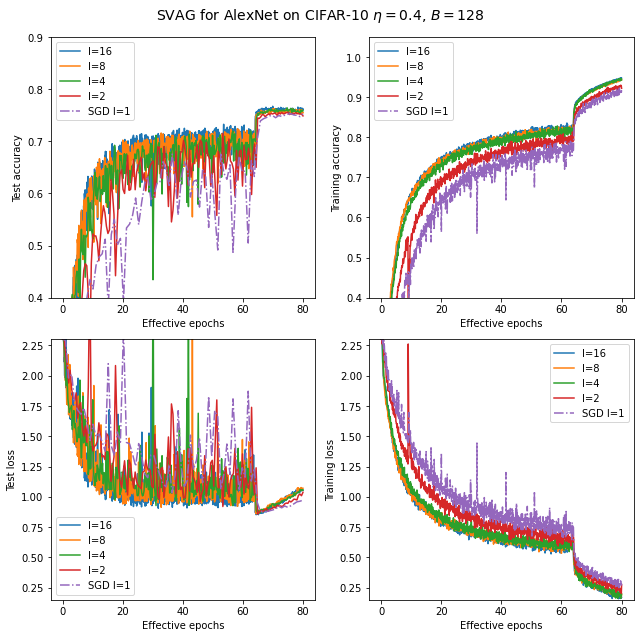

In [26]:
# Presentation
smoothing_factor = 0.001
generate_plot('data/alexnet/128/', 'alexnet128_lr04_presentation', 'SVAG for AlexNet on CIFAR-10 $\eta=0.4$, $B=128$',
              smoothing_factor, [0.15, 2.3], [0.4, 0.9], [0.4, 1.05])


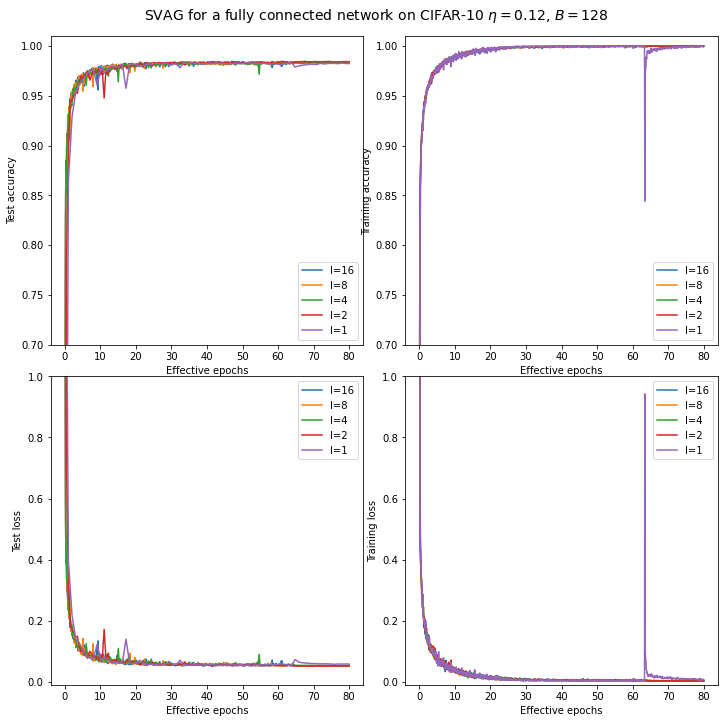

In [133]:
smoothing_factor = 0.001
generate_plot('data/fc/128/', 'fc128_lr012', 'SVAG for a fully connected network on CIFAR-10 $\eta=0.12$, $B=128$',
              smoothing_factor, [-0.01, 1], [0.7, 1.01], [0.7, 1.01])


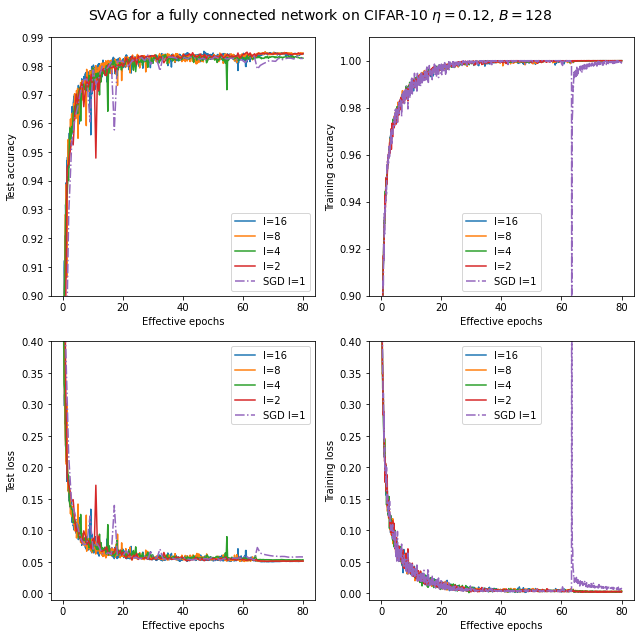

In [24]:
# Presentation
smoothing_factor = 0.001
generate_plot('data/fc/128/', 'fc128_lr012_presentation', 'SVAG for a fully connected network on CIFAR-10 $\eta=0.12$, $B=128$',
              smoothing_factor, [-0.01, 0.4], [0.9, 0.99], [0.9, 1.01])


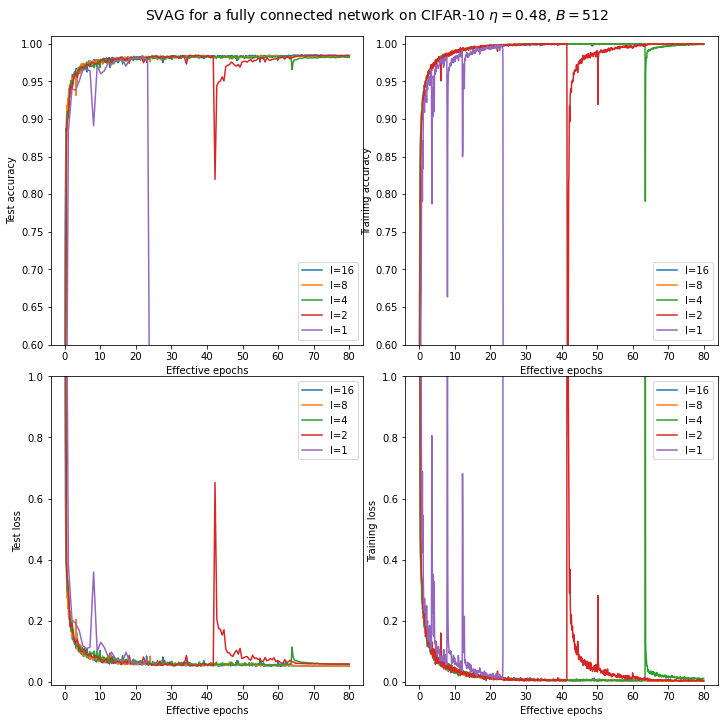

In [134]:
smoothing_factor = 0.001
generate_plot('data/fc/1024/', 'fc512_lr048', 'SVAG for a fully connected network on CIFAR-10 $\eta=0.48$, $B=512$',
              smoothing_factor, [-0.01, 1], [0.6, 1.01], [0.6, 1.01])


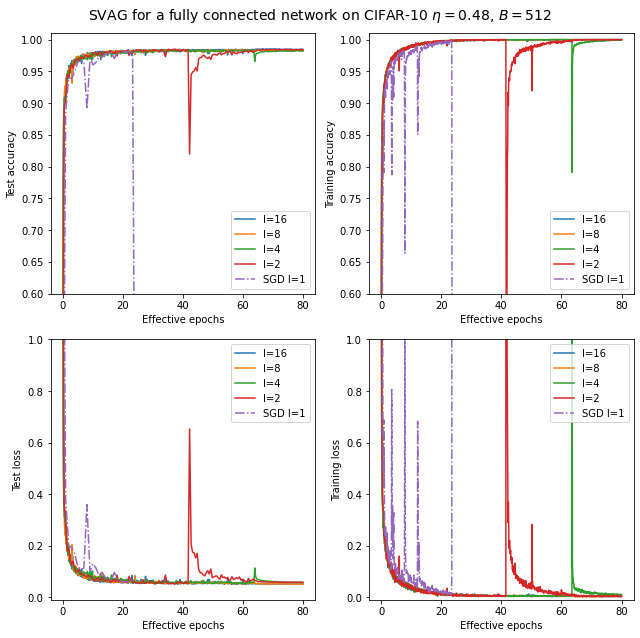

In [25]:
# Presentation
smoothing_factor = 0.001
generate_plot('data/fc/1024/', 'fc512_lr048_presentation', 'SVAG for a fully connected network on CIFAR-10 $\eta=0.48$, $B=512$',
              smoothing_factor, [-0.01, 1], [0.6, 1.01], [0.6, 1.01])


In [15]:
# path = 'data/alexnet/*_16.pt'
# files = glob.glob(path)
# files.sort()
# print(files)
# merged_lists = []
# for first, second in zip(files[:6], files[6:]):
#     data_first = torch.load(first, map_location=torch.device('cpu'))
#     data_second = torch.load(second, map_location=torch.device('cpu'))
#     merged_lists.append(data_first + data_second)
# print(len(merged_lists[2]))
# plt.plot(merged_lists[1], merged_lists[0])
# for file, data in zip(files[6:], merged_lists):
#     torch.save(data, file)
file = 'data/alexnet/epoch_1279_test_loss_16.pt'
len(torch.load(file))


1281